
# WeightWatcher - VGG

https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96


VGG is one of the first, large scale modern architectures based on the classic convolutional model of LeCun ,, resembling a larger scale version of LeNet5.  While there are earlier models (AlexNet, etc), VGG is usefukl because:

-  There are several variants, with 11, 13, 16, and 19 layers, and with and wthout Batch Normalization
-  It is widely available in pyTorch and other frameworks
-  There are versions trained on all of ImageNet, ImageNet-1K (a smaller data set), etc.
-  Although large,  is still used in Transfer Learning.

The general VGG series architecture consists of 

-  Several sets of Conv2D+ReLU layers (followed by Max Pooling), with feature maps increasing in size
-  3 final Fully Connected (Dense/Linear) layers

Below we show the VGG16 architecture, consisting of 16 layers.

The VGG series are considered very large models, with an enormous number of parameters comparexd to later models like ResNet and DenseNet series.  Most notably, compared to later models,

-  VGG models contain large, FC layers at the end
-  VGG does not contain residual connections


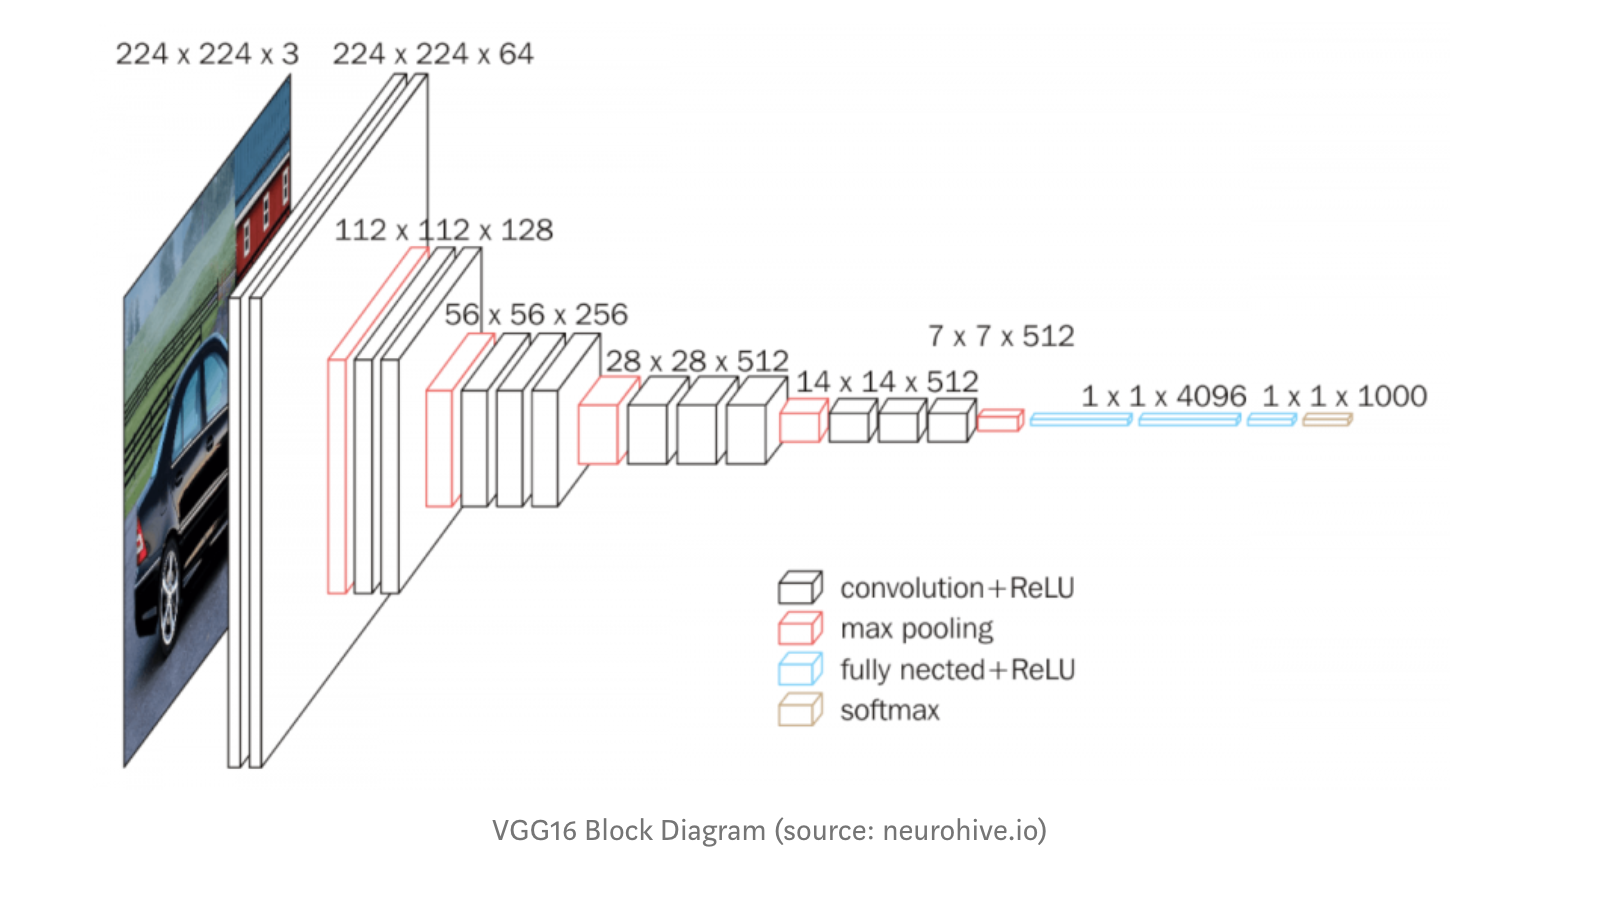

In [1]:
from IPython.display import Image
Image(filename='VGG16.1.png',width=800, height=400)


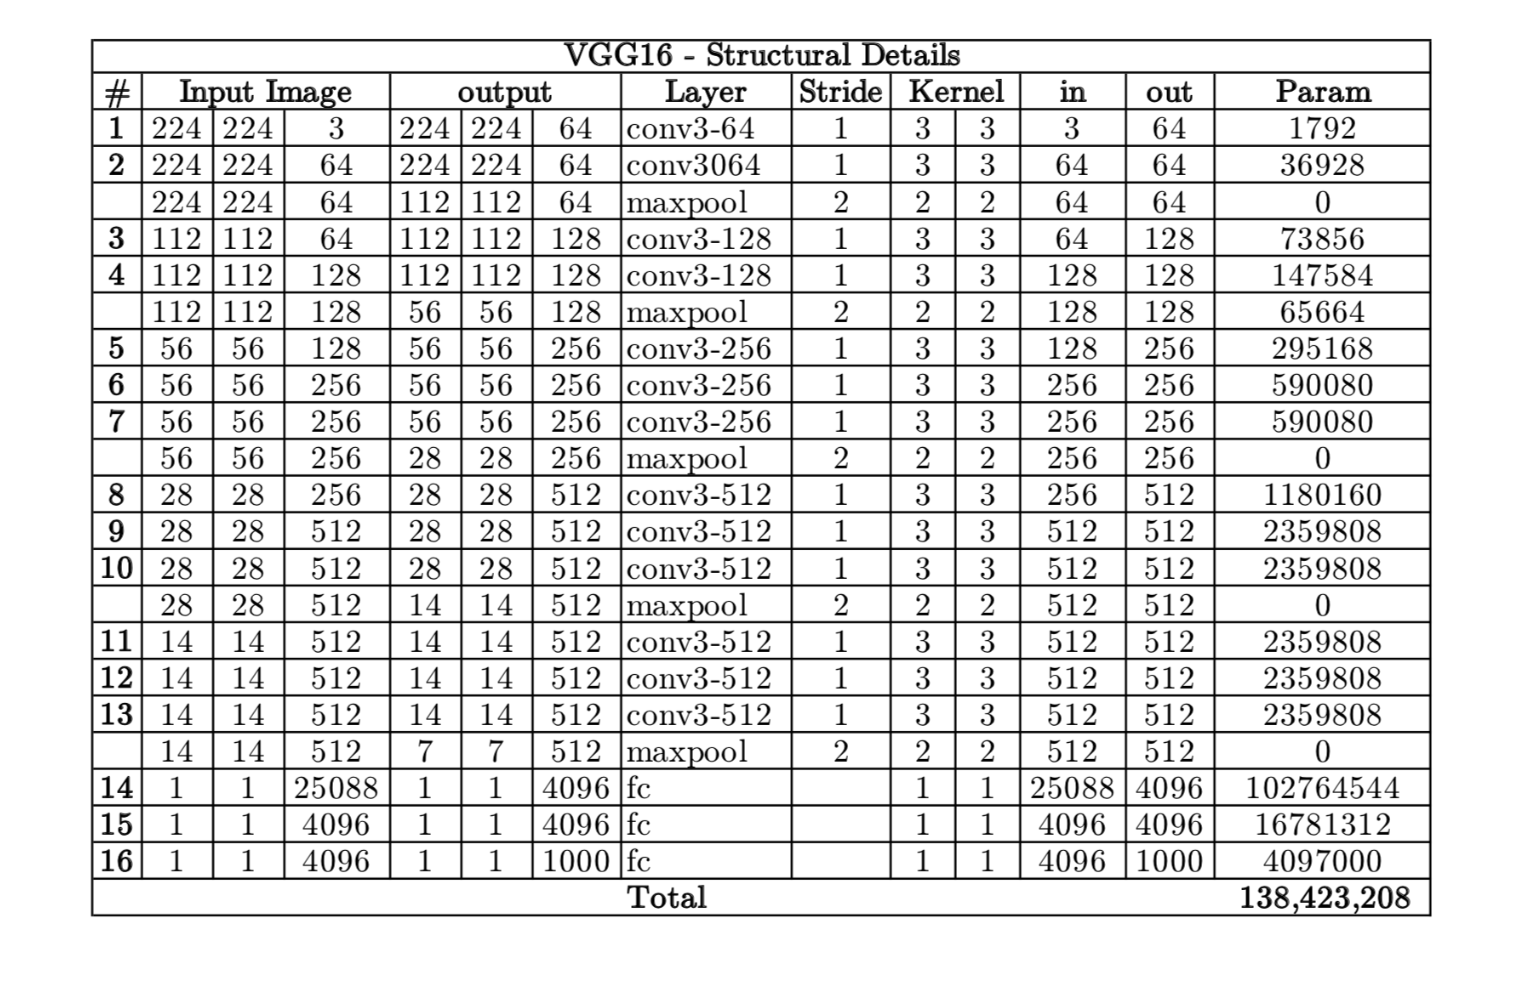

In [2]:
Image(filename='VGG16.2.png',width=800, height=400)

It is noted that the VGGNet model (16?) has ov er 2X the number of parameters as one of the largest ResNet models, with far less top5 accuracy.  

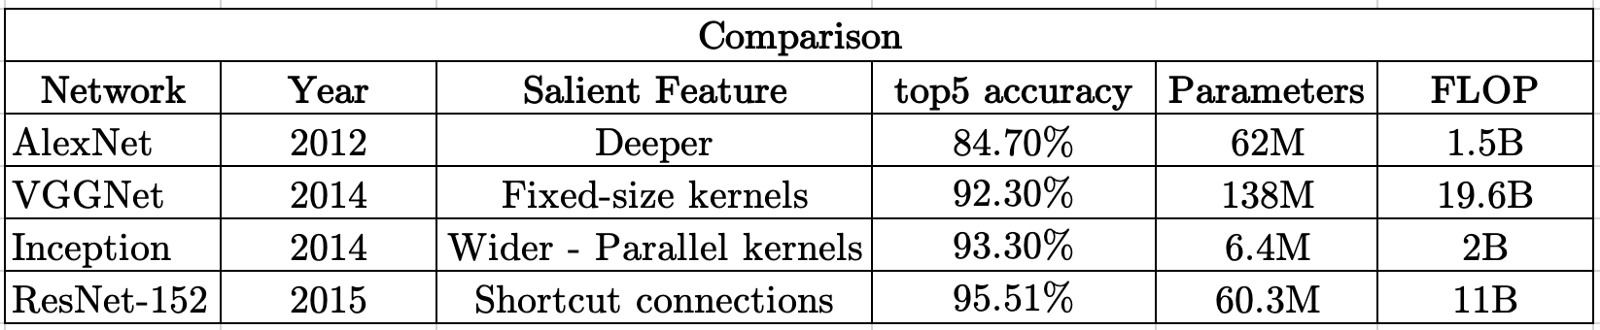

In [3]:
from IPython.display import Image
Image(filename='CV-models.png',width=800, height=400)

## Summary of results


We first compute the Average Alpha $\langle\alpha\rangle$ for all models, and compare to the Test Accuracy accross the models.  In contrast to expectations, and other models like ResNet, on average, $\langle\alpha\rangle$ is increasing with Test Accuracy instead of decreasing.  In fact, $\langle\alpha\rangle$ is strongly *negatively correlated* with reported Test Accuracy.  

#### Why is this ?

If we look at $\alpha$ vs Layer Id, we see that  $\alpha$ is increasing with Layer Id. That is, as information flows thorugh the network, the layers are less and less correlated.  THis suggests (to me) that the VGG networks are fairly bad at funneling information through the network.

Instead, we need to use the Weighted Alpha metric $\hat{\alpha}$ , which is positively correlated with the Test Accuracy.  

## Calculation of Results

In [4]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [6]:
import weightwatcher as ww
import torchvision.models as models

ww.__version__

'0.4.0'

###  Helper Notebook to make Plots


In [7]:
import import_ipynb
import ModelPlots as MP

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

Pick colors from https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [8]:
series_name = 'VGG'
all_names = [ 'vgg11', 'vgg13',  'vgg16',  'vgg19', ]
colors =    ['indigo', 'purple','darkgreen', 'red']


all_models = []
all_models.append(models.vgg11(pretrained=True))

#all_models.append(models.vgg13(pretrained=True))

#all_models.append(models.vgg16(pretrained=True))

#all_models.append(models.vgg19(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>VGG-11</p></td>
<td><p>30.98</p></td>
<td><p>11.37</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13</p></td>
<td><p>30.07</p></td>
<td><p>10.75</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16</p></td>
<td><p>28.41</p></td>
<td><p>9.62</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19</p></td>
<td><p>27.62</p></td>
<td><p>9.12</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-11 with batch normalization</p></td>
<td><p>29.62</p></td>
<td><p>10.19</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13 with batch normalization</p></td>
<td><p>28.45</p></td>
<td><p>9.63</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16 with batch normalization</p></td>
<td><p>26.63</p></td>
<td><p>8.50</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19 with batch normalization</p></td>
<td><p>25.76</p></td>
<td><p>8.15</p></td>
</tr>
</tbody>
</table>
</pre>

In [9]:
top1_errors= {
    
    "vgg11": 30.98,
    "vgg11_bn": 29.62,
    "vgg13": 30.07,
    "vgg13_bn": 28.45,
    "vgg16": 28.41,
    "vgg16_bn": 26.63,
    "vgg19": 27.62,
    "vgg19_bn": 25.76,
}

In [10]:
top5_errors= {
    
    "vgg11": 11.37,
    "vgg11_bn": 10.19,
    "vgg13": 10.75,
    "vgg13_bn": 9.63,
    "vgg16": 9.62,
    "vgg16_bn": 8.50,
    "vgg19": 9.12,
    "vgg19_bn": 8.15,
}

In [11]:
all_models[0]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [12]:
watcher = ww.WeightWatcher(model=all_models[0])

INFO:WeightWatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0


### Run WeightWatcher, collect summary and details (as dataframes) for all models

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 64x3 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=64 M=3 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
DEBUG:WeightWatcher:Running full SVD:  W.shape=(64, 3)  n_comp = 3
INFO:WeightWatcher:fitting power law on 27 eigenvalues
DEBUG:matplotlib.ticker:vmin 21.426543119841792 vmax 121.08551345586987
DEBUG:matplotlib.ticker:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 4.971363636363637
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSSymbols-Regular.otf) normal normal 400 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=24.0 to DejaVu Sans ('/Users/charleshmartin/anaconda3/envs/ww0.4/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRou

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 n

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSSymbols-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to STIXGeneral ('/Users/charleshmartin/anaconda3/envs/ww0.4/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuS

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Bold.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) ital

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal 500 condensed>) = 11.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.tt

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Semibold.otf) normal normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSSymbols-Regular.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_mana

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=20.0 to STIXGeneral ('/Users/charleshmartin/anaconda3/envs/ww0.4/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGenera

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Bold.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Light.otf) normal normal 300 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.fon

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.535
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSSymbols-Regular.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal 700 con

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 10.434999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Fon

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Light.otf) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 10.05
DEBUG:m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matp

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Seravek' (Seravek.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal 300 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 10.62
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal 800 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-MediumItalic.otf) italic normal 500 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal 400 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findf

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Seravek' (Seravek.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal 300 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 10.145
DEBUG:mat

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal 400 normal>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Thin.otf) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 100 normal>) = 10.335
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Seravek' (Seravek.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal 300 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: s

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSText.ttf) normal normal 400 normal>) = 10.05
DEB

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Thin.otf) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<F

DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.f

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Black.otf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 200 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fo

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matp

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 10.3449

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinha

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findf

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 900 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fin

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-UltralightItalic.otf) italic normal 100 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal 800 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSize

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 10.3

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-UltralightItalic.otf) italic normal 100 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal 800 condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDev

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 250 normal>) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal 800 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 10.05

DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-UltralightItalic.otf) italic normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 11.05
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal 800 condensed>) = 11.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 250 normal>) = 11.1925
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal 600 condensed>) = 11.44
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Semibold.otf) normal normal 600 

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal 800 normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans:style=italic:variant=normal:weight=normal:stretch=normal:size=20

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farah' (Farah.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 600 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal 400 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.335
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal 600 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal 500 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nade

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 250 normal>) = 10.4775
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal 600 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 10.715
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Semibold.otf) normal normal 600 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSSymbols-Regular.otf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans:style=normal:variant=normal:weight=bold:stretch=normal:size=20.0 to DejaVu Sans ('/Users/charleshmartin/anaconda3/envs/ww0.4/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRou

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Medium.otf) normal normal 500 condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 n

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Semibold.otf) normal normal 600 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSSymbols-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans Mono:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans Mono ('/Users/charleshmartin/anaconda3/envs/ww0.4/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans Display:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaV

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) ital

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008378689528998789 vmax 1.4012493492202687
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+

DEBUG:matplotlib.ticker:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 18.085413649756703 vmax 43.13675543746977
DEBUG:matplotlib.ticker:ticklocs array([   1.,   10.,  100., 1000.])
DEBUG:matplotlib.ticker:vmin 18.085413649756703 vmax 43.13675543746977
DEBUG:matplotlib.ticker:ticklocs array([   1.,   10.,  100., 1000.])
DEBUG:matplotlib.ticker:vmin 18.085413649756703 vmax 43.13675543746977
DEBUG:matplotlib.ticker:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplot

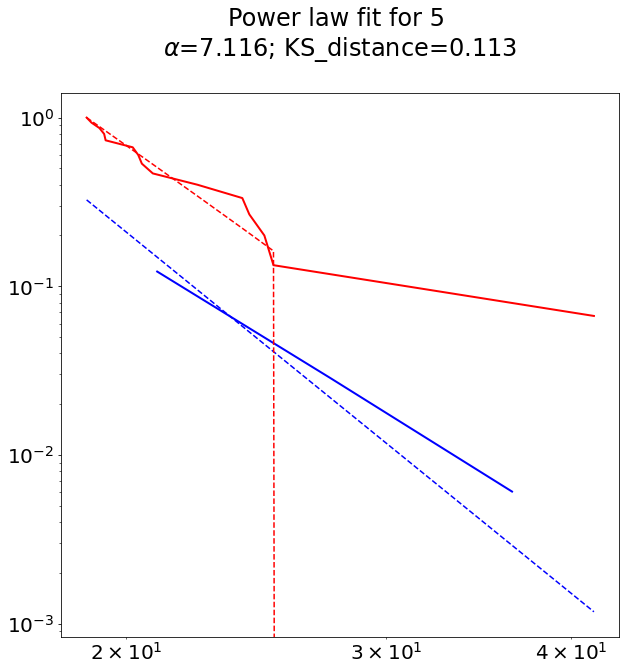

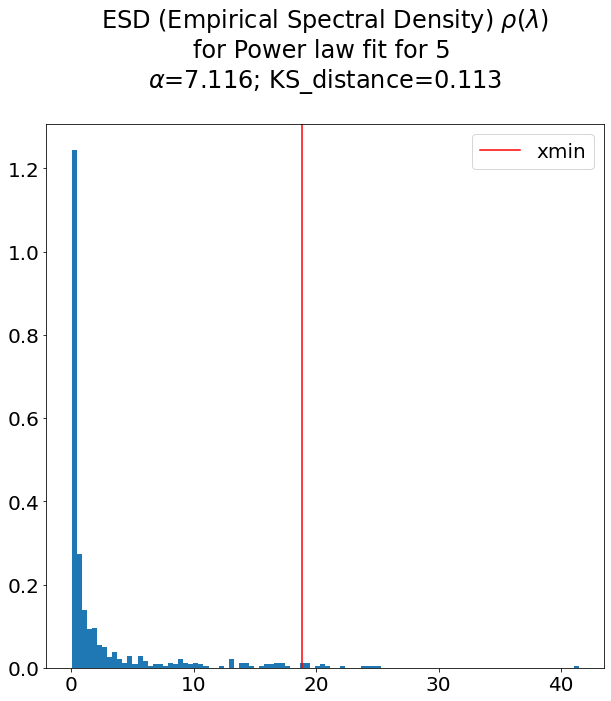

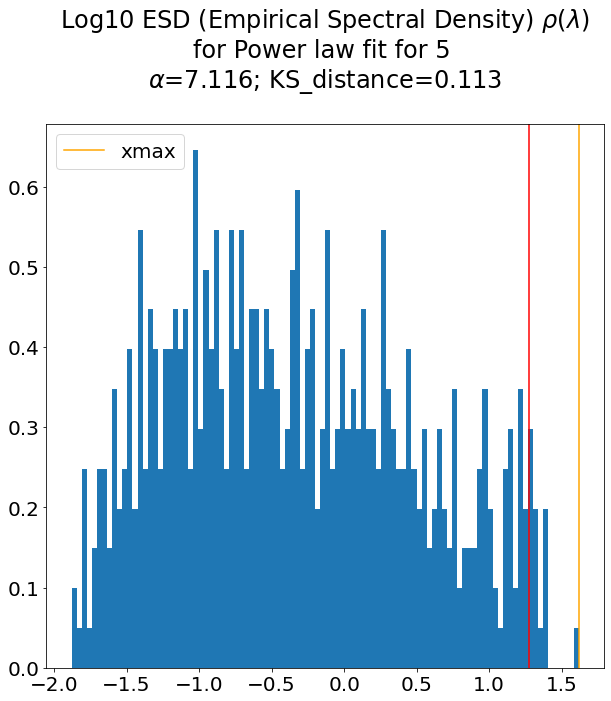

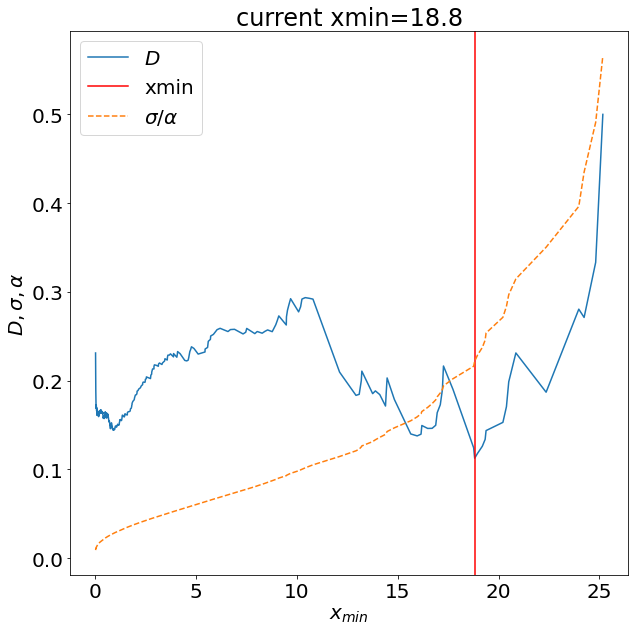

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 256x128 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=256 M=128 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 128)  n_comp = 128
INFO:WeightWatcher:fitting power law on 1152 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 1152 
DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.9

DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.98012629790158
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.98012629790158
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.98012629790158
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.98012629790158
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.98012629790158
DEBUG:matplot

DEBUG:matplotlib.ticker:vmin 4.6005934761614355 vmax 37.98012629790158
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0008080113477454745 vmax 1.4036726412566791
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008080113477454745 vmax 1.4036726412566791
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0008080113477454745 vmax 1.4036726412566791
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
 

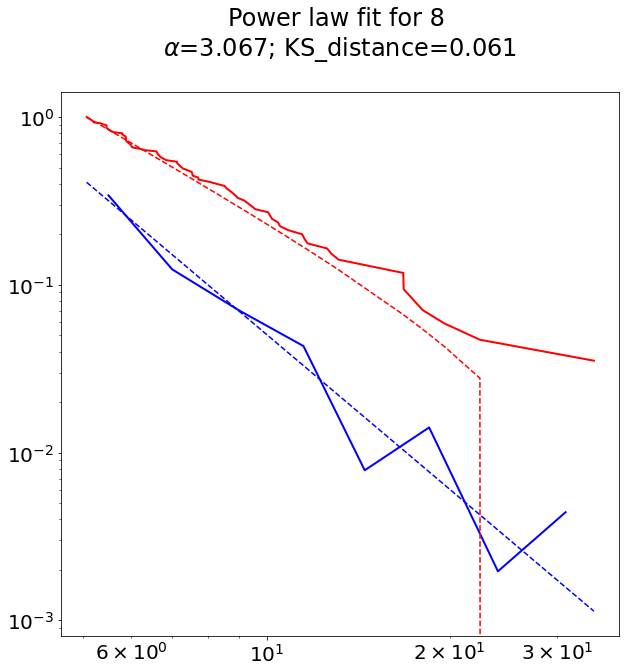

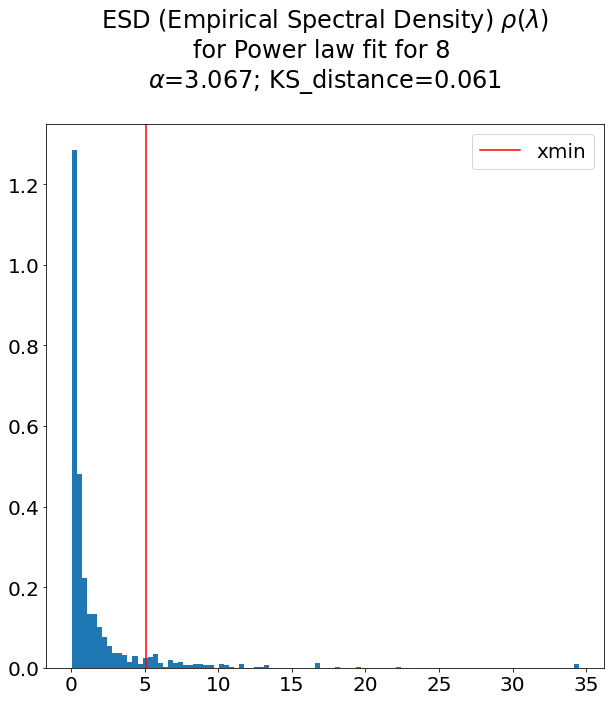

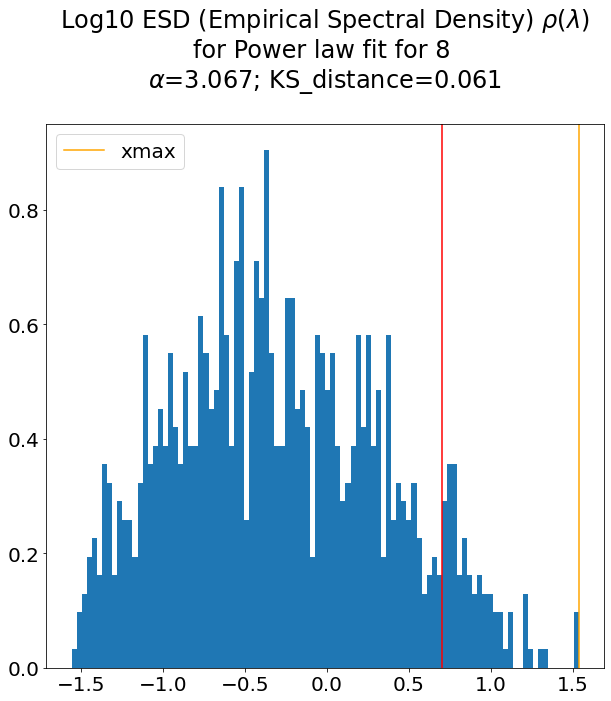

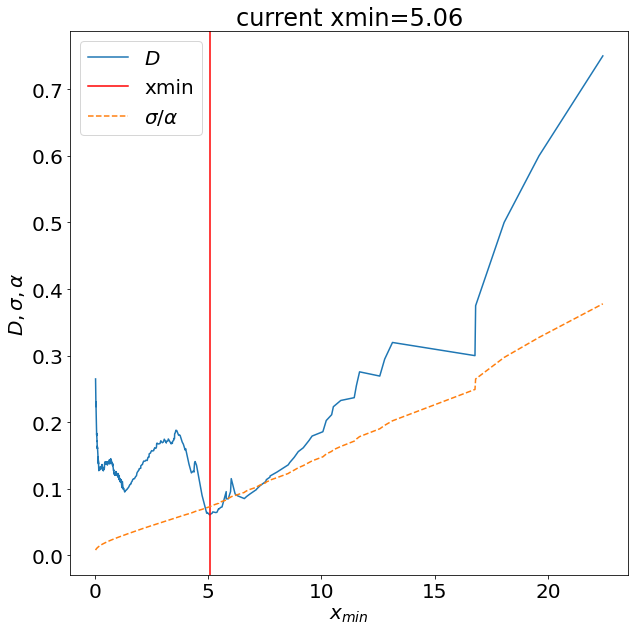

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 256x256 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=256 M=256 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(256, 256)  n_comp = 256
INFO:WeightWatcher:fitting power law on 2304 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 2304 
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.6

DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.61731424030428
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.61731424030428
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.61731424030428
DEBUG:m

DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.61731424030428
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.61731424030428
DEBUG:matplotlib.ticker:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.61731424030428
DEBUG:matplotlib.ticker:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 0.6768195913849901 vmax 19.6173

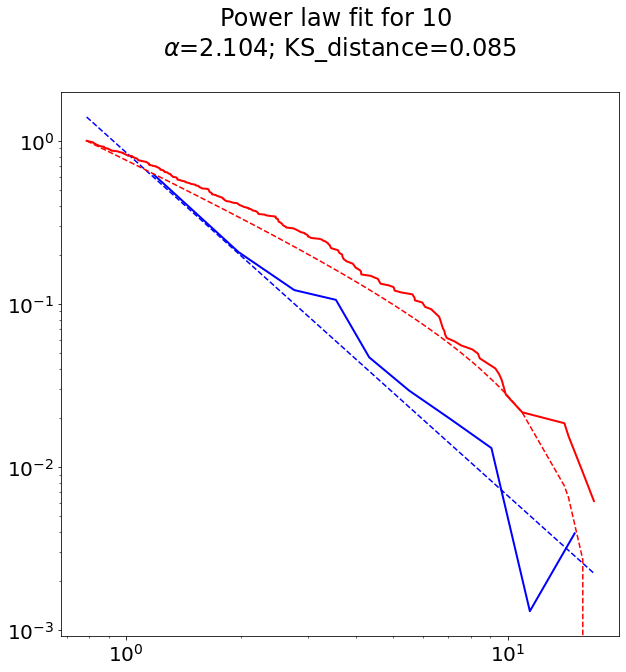

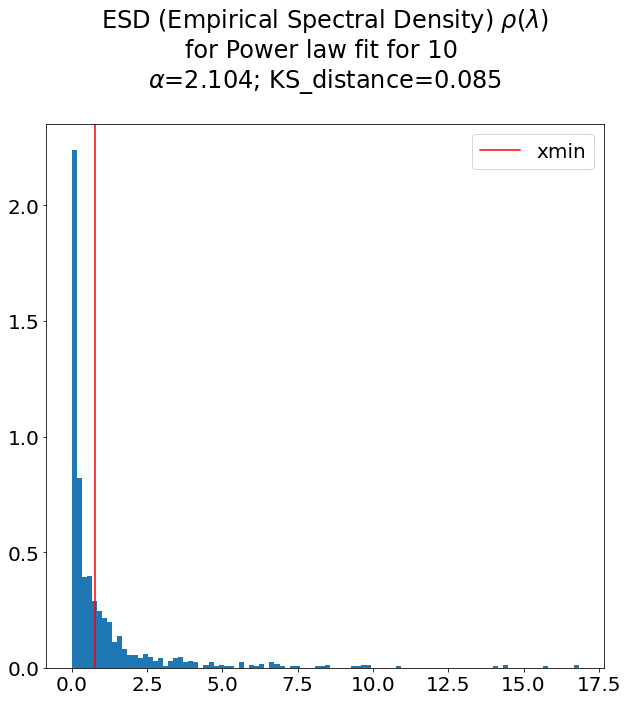

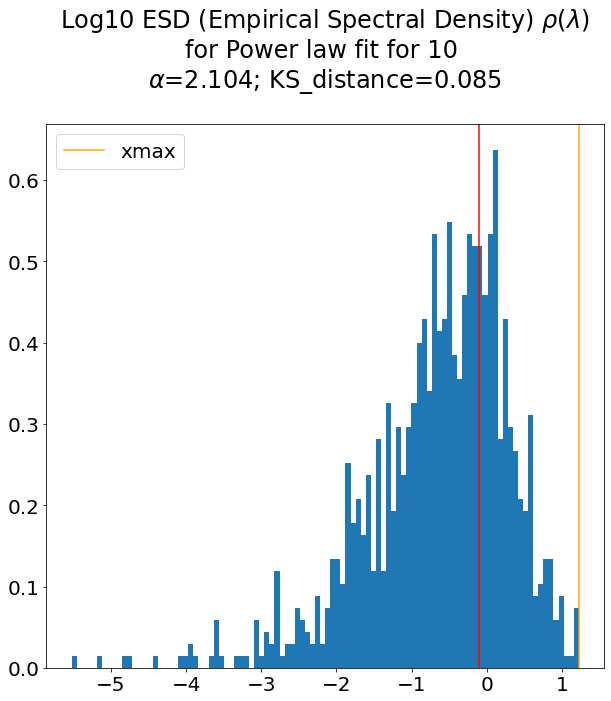

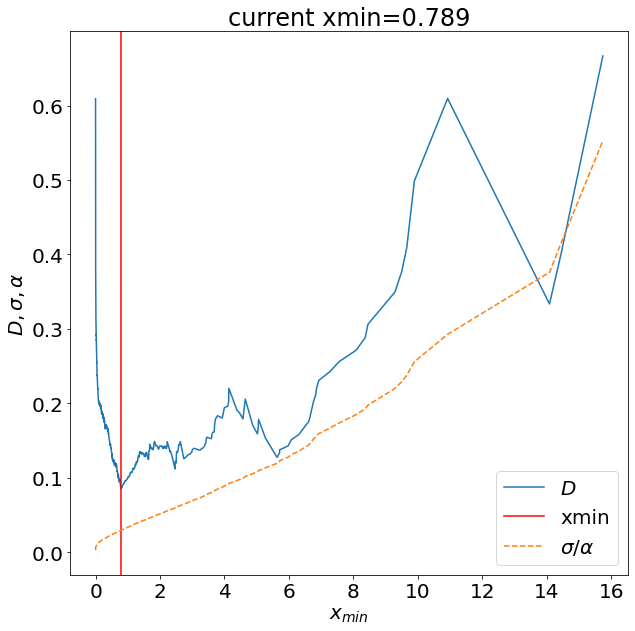

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x256 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=256 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 256)  n_comp = 256
INFO:WeightWatcher:fitting power law on 2304 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 2304 
DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02

DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02311635658191
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02311635658191
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02311635658191
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02311635658191
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02311635658191
DEBUG:matplotlib.t

DEBUG:matplotlib.ticker:vmin 5.191766355526947 vmax 35.02311635658191
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.0006819951723481437 vmax 1.4150517377805232
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0006819951723481437 vmax 1.4150517377805232
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0006819951723481437 vmax 1.4150517377805232
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
  

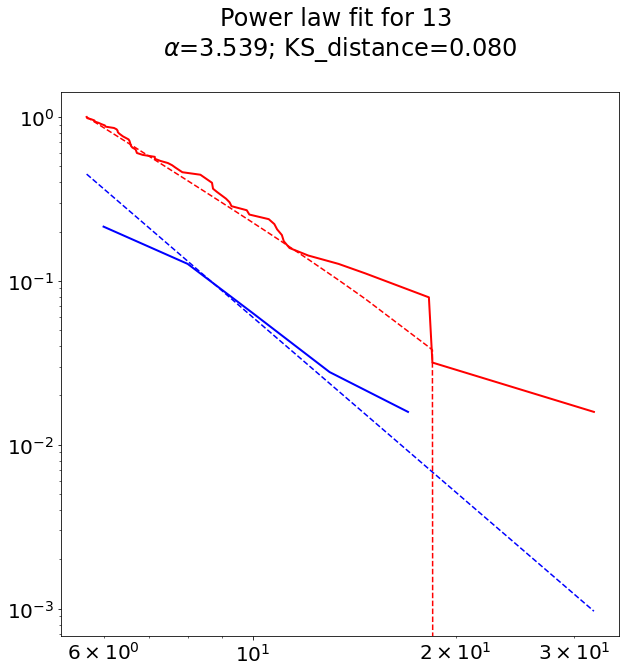

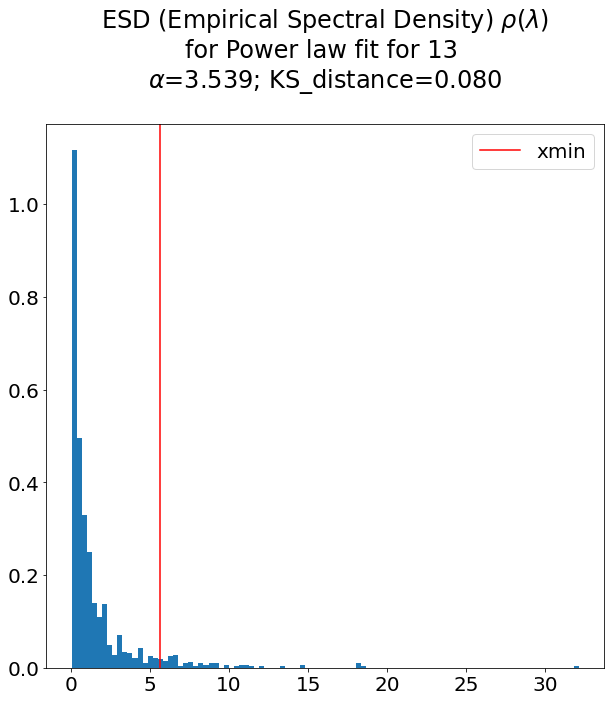

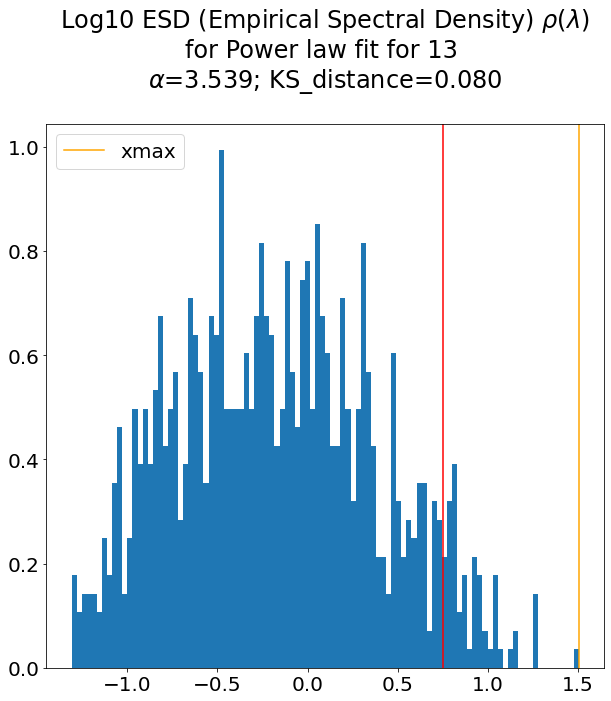

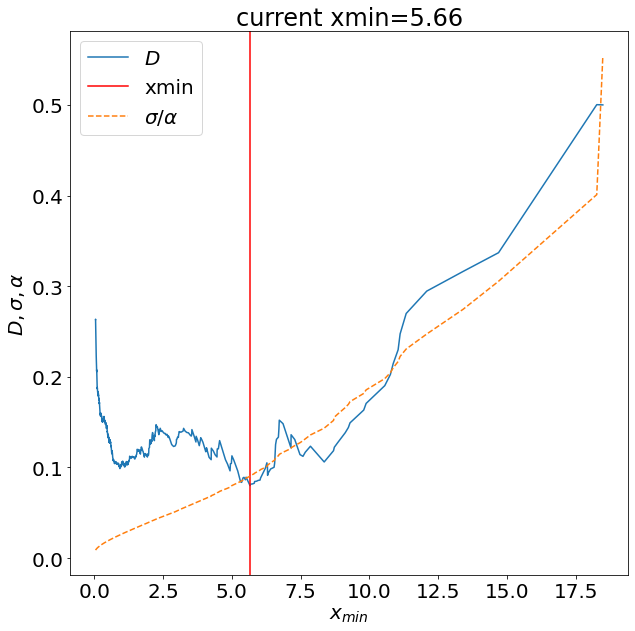

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x512 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=512 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
INFO:WeightWatcher:fitting power law on 4608 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 4608 
DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56

DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56448185024488
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56448185024488
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56448185024488
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56448185024488
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56448185024488
DEBUG:matplotlib.t

DEBUG:matplotlib.ticker:vmin 2.173756791183965 vmax 29.56448185024488
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 0.00028704804782089116 vmax 1.4745816620000165
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.00028704804782089116 vmax 1.4745816620000165
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.00028704804782089116 vmax 1.4745816620000165
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,

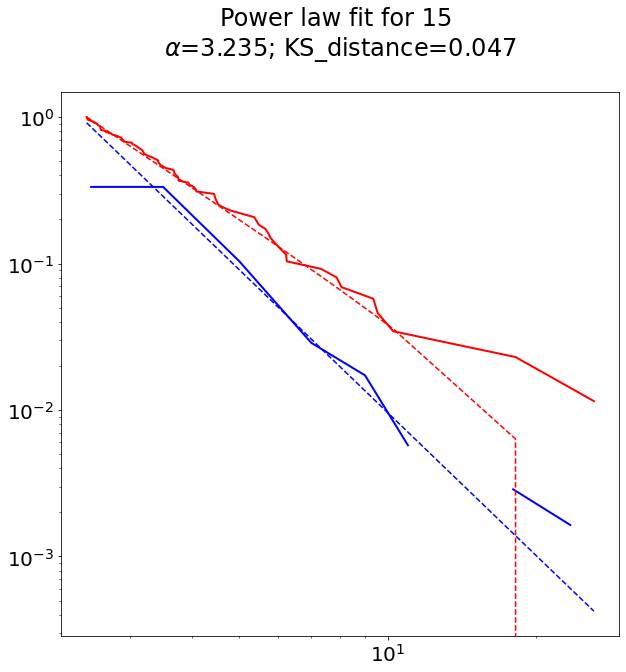

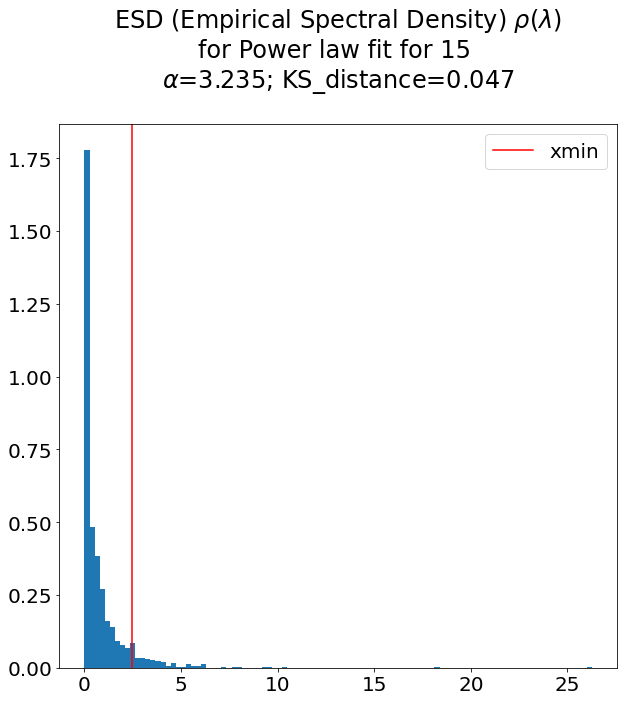

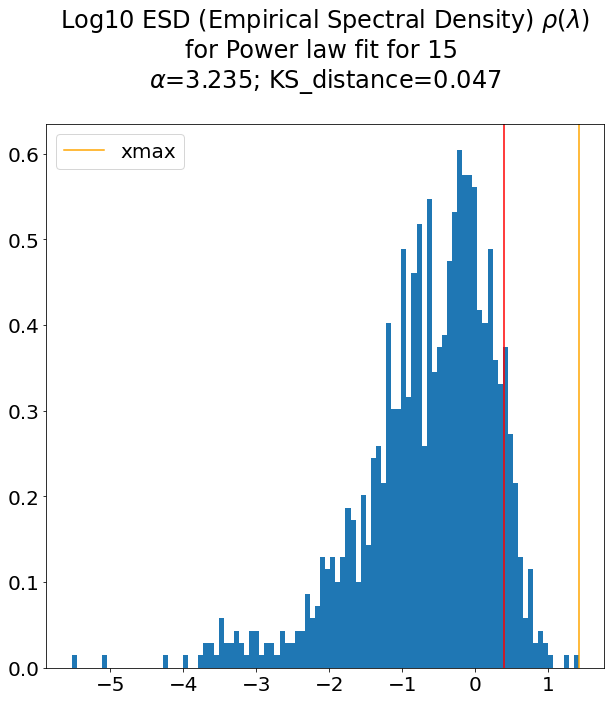

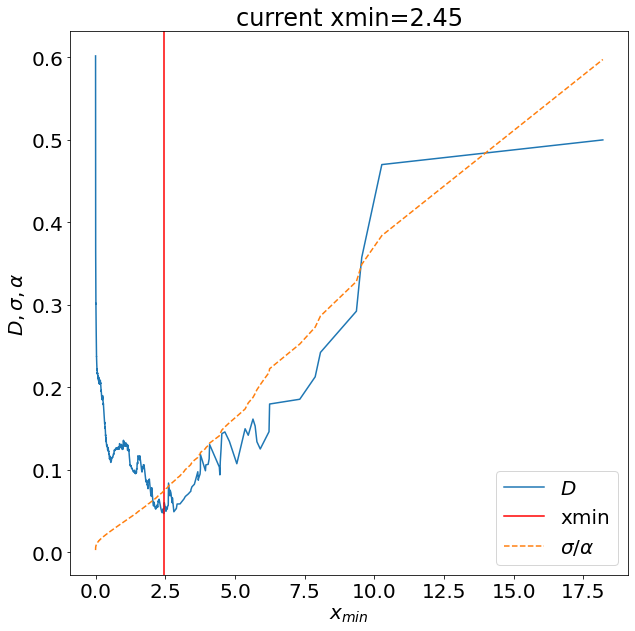

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x512 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=512 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
INFO:WeightWatcher:fitting power law on 4608 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 4608 
DEBUG:matplotlib.ticker:vmin 2.867859162509019 vmax 16.45

DEBUG:matplotlib.ticker:vmin 2.867859162509019 vmax 16.45192874262161
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.867859162509019 vmax 16.45192874262161
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 2.867859162509019 vmax 16.45192874262161
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.867859162509019 vmax 16.45192874262161
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.867859162509019 vmax 16.45192874262161
DEBUG:matplotlib.t

DEBUG:matplotlib.ticker:vmin 0.0025470293534282477 vmax 1.3289914680999688
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0025470293534282477 vmax 1.3289914680999688
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
DEBUG:matplotlib.ticker:vmin 0.0025470293534282477 vmax 1.3289914680999688
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.ticker:vmin 0.0025470293534282477

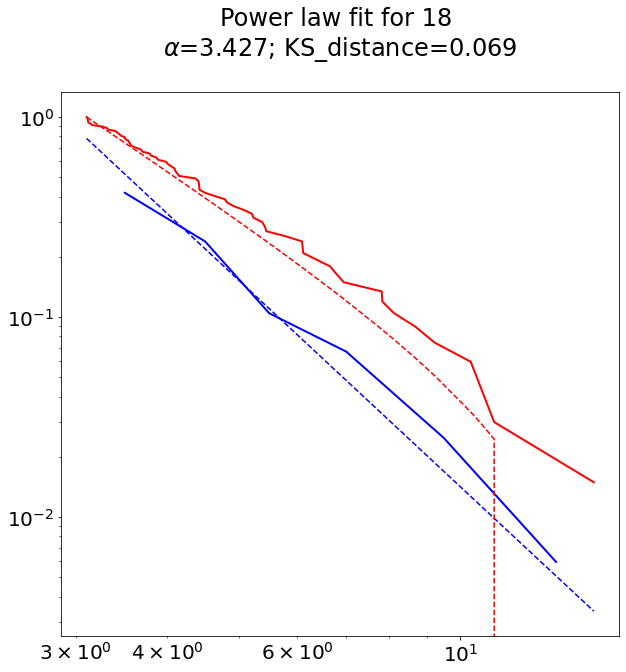

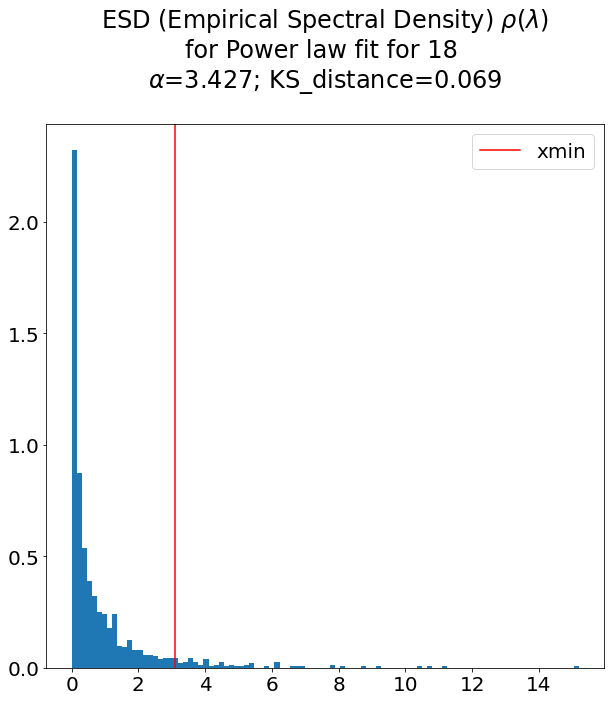

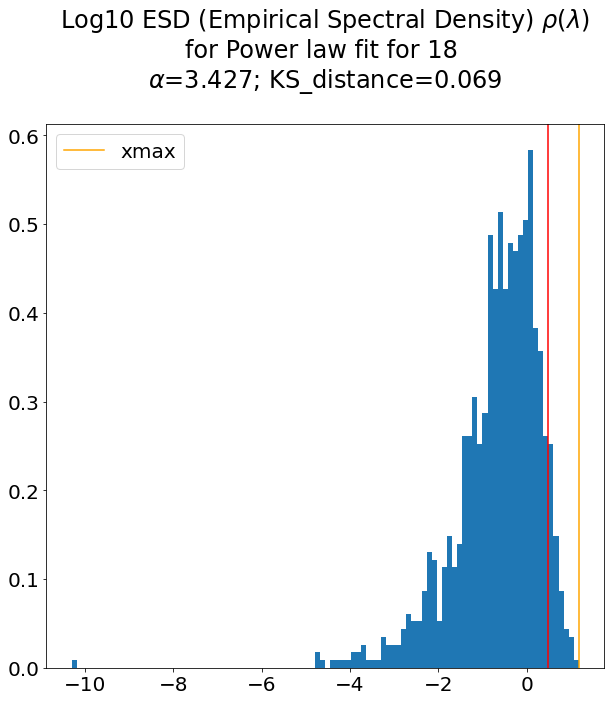

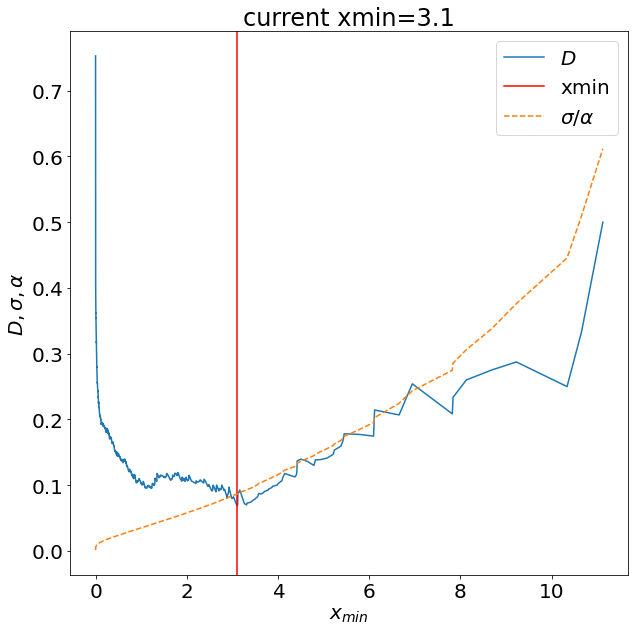

DEBUG:WeightWatcher:conv2D_Wmats
DEBUG:WeightWatcher:Channels Last tensor shape detected: 512x512 (NxM), 3x3 (i,j)
DEBUG:WeightWatcher:get_conv2D_Wmats N=512 M=512 rf= 9 channels = 4
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
DEBUG:WeightWatcher:Running full SVD:  W.shape=(512, 512)  n_comp = 512
INFO:WeightWatcher:fitting power law on 4608 eigenvalues
INFO:WeightWatcher:chosing 1000 eigenvalues from 4608 
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3

DEBUG:matplotlib.ticker:ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:v

DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03])
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
DEBUG:matplotlib.ticker:vmin 2.1449722578742536 vmax 62.3483435142655
DEBUG:matplotlib.t

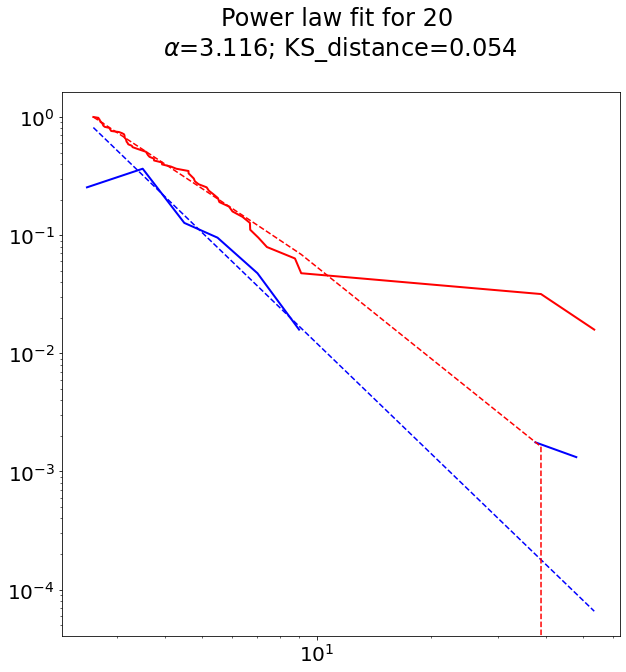

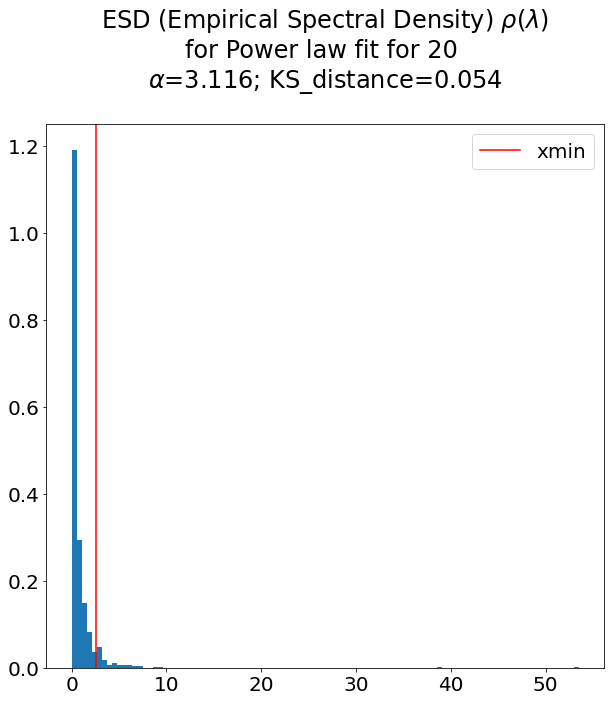

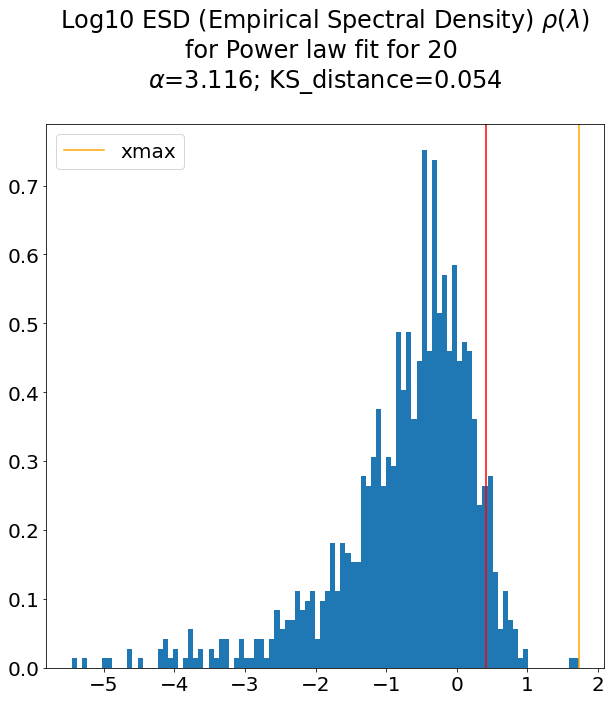

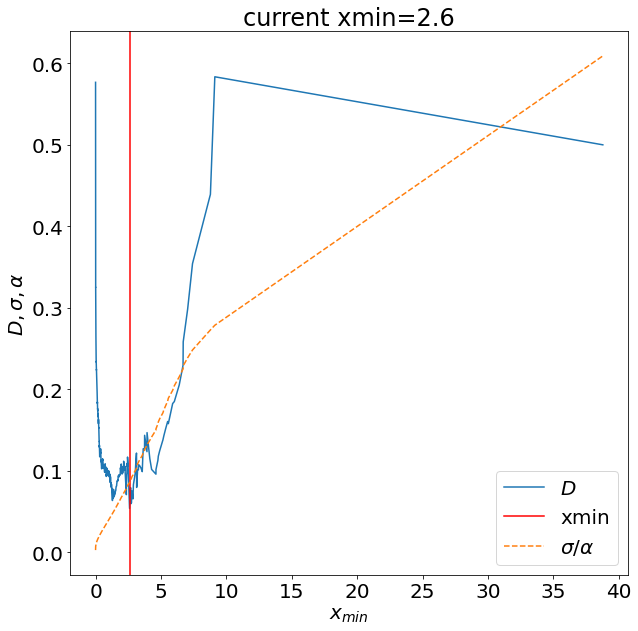

DEBUG:WeightWatcher:Layer 25 : size 25088 > 10000
DEBUG:WeightWatcher:Running full SVD:  W.shape=(4096,)  n_comp = 4096


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [13]:
details = watcher.analyze(alphas=True,  normalize=False, glorot_fix=False, plot=True)

In [ ]:
details